**Package Import and Data Download**

In [36]:
import pandas as pd
import math
import numpy as np
import matplotlib.pylab as plt
import scikitplot as skplt

from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier 
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.compose import make_column_transformer
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import precision_recall_fscore_support, f1_score, precision_score, recall_score, roc_curve, auc
from sklearn.metrics.pairwise import haversine_distances


from dmba import regressionSummary, AIC_score, stepwise_selection, gainsChart, liftChart, classificationSummary, plotDecisionTree
from datetime import datetime

%matplotlib inline

In [37]:
fundraise = pd.read_csv("/Users/sanjayregiphilip/OneDrive/DS/ADS505/Module4/Fundraising.csv")
fundraise = fundraise.drop(columns=['Row Id','Row Id.'])

fundraise.head(3)

,zipconvert_2,zipconvert_3,zipconvert_4,zipconvert_5,homeowner dummy,NUMCHLD,INCOME,gender dummy,WEALTH,HV,...,IC15,NUMPROM,RAMNTALL,MAXRAMNT,LASTGIFT,totalmonths,TIMELAG,AVGGIFT,TARGET_B,TARGET_D
0,0,1,0,0,1,1,5,1,9,1399,...,1,74,102.0,6.0,5.0,29,3,4.857143,1,5.0
1,1,0,0,0,1,1,1,0,7,698,...,4,46,94.0,12.0,12.0,34,6,9.400000,1,10.0
2,0,0,0,1,0,2,5,1,8,828,...,13,32,30.0,10.0,5.0,29,7,4.285714,1,5.0


# Question 1 
**Data preparation: Load the data and prepare it for predictive analysis.**


## 1.1 Partition the dataset into 60% training and 40% validation (set the seed to 12345).

**Train Test Split**

In [38]:
trainData, testData = train_test_split(fundraise, test_size=0.4, random_state=12345)

In [39]:
print("Train data shape", trainData.shape)
print("Validation data shape", testData.shape)

Train data shape (1872, 22)
Validation data shape (1248, 22)


# Question 2 
**Model Building: Follow the following steps to build, evaluate, and choose a model.**

## 2.1. Select classification tool and parameters: Run at least two classification models of your choosing. Be sure NOT to use TARGET_D in your analysis. Describe the two models that you chose, with sufficient detail (method, parameters, variables, etc.) so that it can be replicated.

In [40]:
## Remove TARGET_D
trainData = trainData.drop(columns=['TARGET_D'])
testData = testData.drop(columns=['TARGET_D'])

In [41]:
## Split Predictors from Response Variable
trainX = trainData.drop(columns=['TARGET_B'])
trainY = trainData['TARGET_B']

testX = testData.drop(columns=['TARGET_B'])
testY = testData['TARGET_B']

**Logistic Regression**

In [42]:
## Create and Train Logistic Regression using training data
# Used hyperparameters to ensure penalty for wrong predictions would be included
logit_fund = LogisticRegression(penalty="l2", solver='liblinear', class_weight = "balanced")
logit_fund.fit(trainX, trainY)

## find initial results of the training predictions
classificationSummary(trainY, logit_fund.predict(trainX))

Confusion Matrix (Accuracy 0.5673)

       Prediction
Actual   0   1
     0 521 401
     1 409 541


**Decision Tree**

Confusion Matrix (Accuracy 0.5855)

       Prediction
Actual   0   1
     0 647 275
     1 501 449


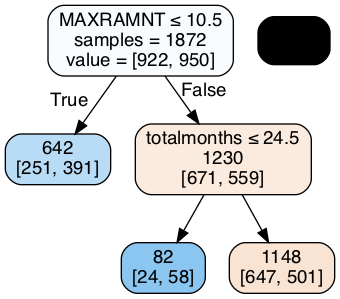

In [43]:
## Create and Train Decisiion Tree using training data
# Included hyperparameters for a readable tree
fundTree = DecisionTreeClassifier(random_state = 12345, max_depth = 7, min_impurity_decrease = 0.005)
fundTree.fit(trainX, trainY)

## find initial results of the training predictions

classificationSummary(trainY, fundTree.predict(trainX))
plotDecisionTree(fundTree, feature_names=trainX.columns)

**Description of models**

The first model created is a logistic regression trained with an l2 penalty to account for missclassifications and also with the hyperparameter of class_weight set to balanced as the training dataset is supposed to be split at 50% donors and 50% non donors.

The second model created is a decision tree that was experimented with different levels of max_depth and min_impurity in order to find the optimal tree that was readable and provided the best results on the training dataset.

## 2.2. Classification under asymmetric response and cost: What is the reasoning behind using weighted sampling to produce a training set with equal numbers of donors and non-donors? Why not use a simple random sample from the original dataset?

**Answer:** Using weighted sampling, and in this case "oversampling" the target donor class is often helpful in cases where the postitive class, the class that we are specifically targeting, has a very low response rate and where we are interested in learning more about a class that is very small. As an example, if we were to randomly sample this dataset, because the target class is such a small percentage of 5.1%, it's possible that in our sample we would either have none of the target class chosen, or such a small number of positive responses from which our models would not be able to learn anything. Additionally, when working with small samples, the models may default to predicting everything as not positive and in doing so would be highly accurate for most classifications but nevertheless miss out on the actual positive class. By using weighted sampling for our training data, we are able to learn more about and catch the more valuable positive responders that we are interested in.

## 2.3. Calculate net profit: For each method, calculate the cumulative gains of net profit for both the training and validation sets based on the actual response rate (5.1%.) 
**Again, the expected donation, given that they are donors, is 13.00, and the total cost of each mailing is 0.68. (Hint: To calculate estimated net profit, we will need to undo the effects of the weighted sampling and calculate the net profit that would reflect the actual response distribution of 5.1% donors and 94.9% non-donors. To do this, divide each row’s net profit by the oversampling weights applicable to the actual status of that row. The oversampling weight for actual donors is 50%/5.1% = 9.8. The oversampling weight for actual non-donors is 50%/94.9% = 0.53.)**

### Calculate Net Profit for Logistic Regression

In [44]:
## Copy dataset for only logistic regression results
trainX_gains_log = trainX.copy(deep=False)
testX_gains_log = testX.copy(deep=False)

## Predict if customer will donate using logistic regression
trainX_gains_log['pred'] = logit_fund.predict(trainX)
testX_gains_log['pred'] = logit_fund.predict(testX)

## Assign the revenue given prediction result
trainX_gains_log['revenue'] = trainX_gains_log['pred'].apply(lambda x: 13 if x == 1 else 0)
testX_gains_log['revenue'] = testX_gains_log['pred'].apply(lambda x: 13 if x == 1 else 0)

## Calculate net profit based on whether they donated or not
trainX_gains_log['net_profit'] = trainX_gains_log['revenue'] - 0.68
testX_gains_log['net_profit'] = testX_gains_log['revenue'] - 0.68

In [45]:
## Divide net profit by the weighted discount factor
trainX_gains_log['discount_factor'] = trainX_gains_log['pred'].apply(lambda x: 9.8 if x == 1 else 0.53)
testX_gains_log['discount_factor'] = testX_gains_log['pred'].apply(lambda x: 9.8 if x == 1 else 0.53)


trainX_gains_log['weighted_net_profit'] = trainX_gains_log["net_profit"].div(trainX_gains_log["discount_factor"].values)
testX_gains_log['weighted_net_profit'] = testX_gains_log["net_profit"].div(testX_gains_log["discount_factor"].values)

In [46]:
## Find total estimated net profit given the weights

print("Weighted Net Profit using Logistic Regression:", round(testX_gains_log['weighted_net_profit'].sum(),2))

Weighted Net Profit using Logistic Regression: -82.19


### Calculate Net Profit for Decision Tree

In [47]:
## Copy dataset for only decision tree results
trainX_gains_dt = trainX.copy(deep=False)
testX_gains_dt = testX.copy(deep=False)

## Predict if customer will donate using decision tree
trainX_gains_dt['pred'] = fundTree.predict(trainX)
testX_gains_dt['pred'] = fundTree.predict(testX)

## Assign the revenue given prediction result
trainX_gains_dt['revenue'] = trainX_gains_dt['pred'].apply(lambda x: 13 if x == 1 else 0)
testX_gains_dt['revenue'] = testX_gains_dt['pred'].apply(lambda x: 13 if x == 1 else 0)

## Calculate net profit based on whether they donated or not
trainX_gains_dt['net_profit'] = trainX_gains_dt['revenue'] - 0.68
testX_gains_dt['net_profit'] = testX_gains_dt['revenue'] - 0.68

In [48]:
## Divide net profit by the weighted discount factor
trainX_gains_dt['discount_factor'] = trainX_gains_dt['pred'].apply(lambda x: 9.8 if x == 1 else 0.53)
testX_gains_dt['discount_factor'] = testX_gains_dt['pred'].apply(lambda x: 9.8 if x == 1 else 0.53)

trainX_gains_dt['weighted_net_profit'] = trainX_gains_dt["net_profit"].div(trainX_gains_dt["discount_factor"].values)
testX_gains_dt['weighted_net_profit'] = testX_gains_dt["net_profit"].div(testX_gains_dt["discount_factor"].values)

In [49]:
## Find total estimated net profit given the weights

print("Weighted Net Profit using Decision Trees:", round(testX_gains_dt['weighted_net_profit'].sum(),2))

Weighted Net Profit using Decision Trees: -435.27


## 2.4. Draw cumulative gains curves: Draw the different models’ net profit cumulative gains curves for the validation set in a single plot (net profit on the y-axis, proportion of list or number mailed on the x-axis). Is there a model that dominates?**

In [50]:
## Logistic Regression
# predicted probabilities for validation data set

# save weighted net profit to new dataframe
log_result = pd.DataFrame(testX_gains_log['weighted_net_profit'])
tree_result = pd.DataFrame(testX_gains_dt['weighted_net_profit'])


## save sorted dataframe
df_log = log_result.sort_values(by=['weighted_net_profit'], ascending=False)
df_tree = tree_result.sort_values(by=['weighted_net_profit'], ascending=False)

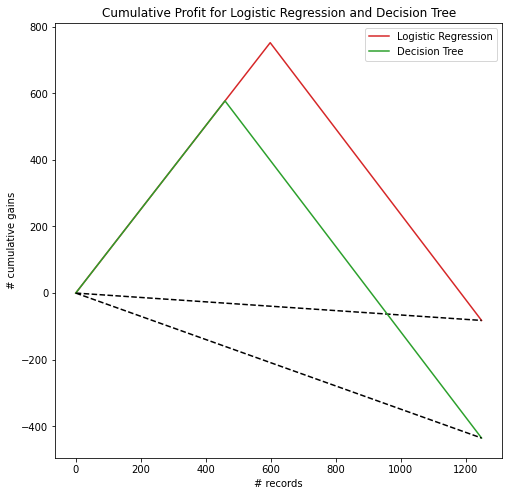

In [51]:
# lift chart for validation set

ax = gainsChart(df_log.weighted_net_profit, label="Logistic Regression", color='C3', figsize=[8,8])
ax = gainsChart(df_tree.weighted_net_profit, label="Decision Tree", color='C2', ax=ax)
ax.legend()
ax.set_title('Cumulative Profit for Logistic Regression and Decision Tree')
plt.show()

**Answer:** Knowing that this dataset consists of 50% donors and 50% non donors, the logistic regression seems to predict many more records as donors, and closer to the 600 (50% of the validation set) target number. With this, we also see a much higher cumulative gain that indicates better performance of the logistic regression model.

## 2.5. Select the best model: From your answer in (4), what do you think is the “best” model?

In [52]:
## Logistic Regression

classificationSummary(testY, logit_fund.predict(testX))

print("\nF1 Score", round(f1_score(testY, logit_fund.predict(testX), average="macro"),4))
print("Precision:", round(precision_score(testY, logit_fund.predict(testX), average="macro"),4))
print("Recall:", round(recall_score(testY, logit_fund.predict(testX), average="macro"),4))


fpr, tpr, thresholds = roc_curve(testY, logit_fund.predict(testX))
print("Auc:", round(auc(fpr, tpr),4))

Confusion Matrix (Accuracy 0.5721)

       Prediction
Actual   0   1
     0 377 261
     1 273 337

F1 Score 0.5717
Precision: 0.5718
Recall: 0.5717
Auc: 0.5717


In [53]:
## Decision Tree

classificationSummary(testY, fundTree.predict(testX))


print("\nF1 Score", round(f1_score(testY, fundTree.predict(testX), average="macro"),4))
print("Precision:", round(precision_score(testY, fundTree.predict(testX), average="macro"),4))
print("Recall:", round(recall_score(testY, fundTree.predict(testX), average="macro"),4))


fpr, tpr, thresholds = roc_curve(testY, fundTree.predict(testX))
print("Auc:", round(auc(fpr, tpr),4))

Confusion Matrix (Accuracy 0.5489)

       Prediction
Actual   0   1
     0 432 206
     1 357 253

F1 Score 0.5394
Precision: 0.5494
Recall: 0.5459
Auc: 0.5459


**Answer:** In addition to the fact that the logistic regression is able to identify more individuals to be part of the postivie class, the logistic regression has a better accuracy, F1, Precision, Recall, and AUC score. Knowing that in application, the positive class will be very small, the logistic regression will be much more valuable as it appears to be able to predict the positive class more effectively.

# Question 3
**Testing: The file FutureFundraising.csv contains the attributes for future mailing candidates.**

## 3.1. Using your “best” model from Step 2 (number 5), which of these candidates do you predict as donors and non-donors? List them in descending order of the probability of being a donor. Starting at the top of this sorted list, roughly how far down would you go in a mailing campaign?**

In [54]:
## read the future fundraiser dataset

fund_future = pd.read_csv("/Users/sanjayregiphilip/OneDrive/DS/ADS505/Module4/FutureFundraising.csv")

# drop unnecessary columns
fund_future = fund_future.drop(columns = ['TARGET_B', 'TARGET_D'])
fund_future = fund_future.drop(columns = ['Row Id', 'Row Id.'])

In [55]:
## predict donor using logistic regression model

prob_class_1 = logit_fund.predict_proba(fund_future)[:, 1] 

# save results in Dataframe
prob_class_1 = pd.DataFrame(prob_class_1)
fund_future['pred_prob'] = prob_class_1
fund_future.head()

,zipconvert_2,zipconvert_3,zipconvert_4,zipconvert_5,homeowner dummy,NUMCHLD,INCOME,gender dummy,WEALTH,HV,...,Icavg,IC15,NUMPROM,RAMNTALL,MAXRAMNT,LASTGIFT,totalmonths,TIMELAG,AVGGIFT,pred_prob
0,0,1,0,0,1,1,1,1,8,923,...,452,3,42,92.0,29.0,15.0,17,8,15.333333,0.576228
1,0,0,1,0,0,1,2,1,9,724,...,453,4,21,30.0,20.0,20.0,33,9,15.000000,0.384069
2,0,0,0,1,0,1,1,0,4,1153,...,376,10,61,220.0,35.0,25.0,31,9,24.444444,0.406370
3,0,0,0,0,1,1,4,0,1,551,...,283,21,32,41.0,19.0,19.0,31,13,13.666667,0.369161
4,0,0,1,0,1,1,7,1,9,2214,...,850,1,47,46.0,10.0,10.0,28,8,5.750000,0.579370


In [56]:
## sort dataframe by probability someone is a donor
fund_future = fund_future.sort_values(by=['pred_prob'], ascending=False).reset_index(drop=True)
fund_future.head()

,zipconvert_2,zipconvert_3,zipconvert_4,zipconvert_5,homeowner dummy,NUMCHLD,INCOME,gender dummy,WEALTH,HV,...,Icavg,IC15,NUMPROM,RAMNTALL,MAXRAMNT,LASTGIFT,totalmonths,TIMELAG,AVGGIFT,pred_prob
0,0,0,0,1,1,1,4,1,9,3630,...,816,6,114,279.00,25.0,25.0,17,5,14.684211,0.768460
1,0,0,0,1,1,1,4,1,4,649,...,294,29,101,187.00,21.0,10.0,18,11,11.000000,0.766695
2,1,0,0,0,1,1,6,0,1,431,...,200,37,98,181.64,20.0,10.0,17,3,9.082000,0.750430
3,1,0,0,0,1,1,5,0,9,1651,...,429,9,108,169.00,11.0,5.0,18,13,6.259259,0.750040
4,0,0,1,0,1,1,3,1,3,577,...,378,23,148,422.00,30.0,5.0,19,19,10.047619,0.747847


array([[<AxesSubplot:title={'center':'pred_prob'}>]], dtype=object)

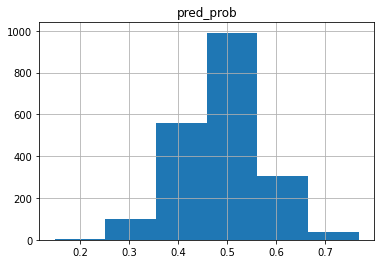

In [57]:
fund_future.hist(column=['pred_prob'],  bins=6)

In [58]:
## Copy dataset for future fundraise logisitic regression results
future = fund_future.drop(columns = ['pred_prob'])

## Predict if customer will donate (needs to be redone previous was probabilities)
future['pred'] = logit_fund.predict(future)

## Assign the revenue given prediction result
future['revenue'] = future['pred'].apply(lambda x: 13 if x == 1 else 0)

## Calculate net profit based on whether they donated or not
future['net_profit'] = future['revenue'] - 0.68

In [59]:
# save net profit to new dataframe
future_result = pd.DataFrame(future['net_profit'])

## save sorted dataframe
df_future = future_result.sort_values(by=['net_profit'], ascending=False)

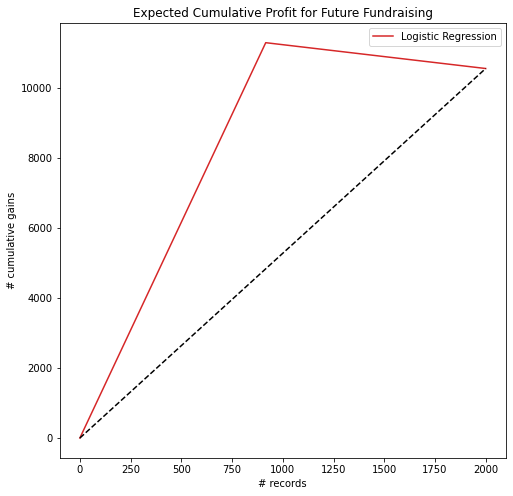

In [60]:
# lift chart for fundraise dataset

ax = gainsChart(df_future.net_profit, label="Logistic Regression", color='C3', figsize=[8,8])
ax.legend()
ax.set_title('Expected Cumulative Profit for Future Fundraising')
plt.show()

In [61]:
len(future.loc[future['net_profit'] > 0])

916

**Answer:** Using the logistic regression to identify potential donors, there are 916 records out of the fundraising future dataset of 2000 where there is a strong probability that the individual will likely donate and where a postiive net profit is also predicted. Therefore, I would choose to only target those 916 individuals.

Please note that for the future dataset, weighted net profit was not utilized because in the real world, the overall distrubition of the target class is not known although for past records it was 5.3%.

**Please continue to next page for Question 3.2**